In [1]:
import numpy as np
from pymongo import MongoClient

client = MongoClient("mongodb://localhost:27017/")
coll = client["News"]["features_transf"]

X_list, y_list = [], []
for d in coll.find({}, {"_id":0}).sort("idx", 1):
    X_list.extend(d["X"])
    y_list.extend(d["y"])
X_rec = np.array(X_list, dtype=np.float32)
y_rec = np.array(y_list)
print(X_rec.shape, y_rec.shape)

(44898, 384) (44898,)


In [2]:
X_rec

array([[-0.00571335, -0.01181866,  0.11246178, ..., -0.02056177,
        -0.01550724,  0.04333217],
       [-0.03696502, -0.01012629,  0.01049643, ...,  0.01222438,
         0.09800622, -0.08014852],
       [-0.04835157,  0.00254504, -0.08660771, ..., -0.05290084,
        -0.01847824, -0.02700369],
       ...,
       [ 0.0706904 ,  0.01349849, -0.06759915, ..., -0.03579082,
         0.04324223, -0.06018719],
       [ 0.01697215, -0.050737  , -0.02502686, ..., -0.08321066,
        -0.04254831, -0.05337545],
       [-0.05448975, -0.00725761, -0.04342892, ..., -0.116878  ,
        -0.03769731,  0.03240921]], dtype=float32)

In [3]:
y_rec

array([1, 1, 1, ..., 0, 0, 0])

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Riproducibilità
np.random.seed(42)
tf.random.set_seed(42)

print("Shape X:", X_rec.shape, "dtype:", X_rec.dtype)
print("Shape y:", y_rec.shape, "dtype:", y_rec.dtype)


Shape X: (44898, 384) dtype: float32
Shape y: (44898,) dtype: int64


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Etichette: da stringhe a int
y = (y_rec.astype(str) == '1').astype(int)   # 1=fake, 0=vera
X = X_rec.astype(np.float32)

# Split stratificato: 70% train, 15% val, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# Class weights (per gestire squilibrio)
classes = np.unique(y_train)
class_weights = compute_class_weight("balanced", classes=classes, y=y_train)
class_weight = {int(c): float(w) for c, w in zip(classes, class_weights)}
print("class_weight:", class_weight)


Train: (31428, 384) Val: (6735, 384) Test: (6735, 384)
class_weight: {0: 1.0481590181430096, 1: 0.9560720369919689}


In [6]:
def build_mlp(input_dim, hidden=(256, 128), dropout=0.30, l2=1e-4, lr=1e-3):
    inputs = keras.Input(shape=(input_dim,), name="dense_features")
    x = layers.BatchNormalization()(inputs)

    x = layers.Dense(hidden[0], activation="relu",
                     kernel_regularizer=keras.regularizers.l2(l2))(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(hidden[1], activation="relu",
                     kernel_regularizer=keras.regularizers.l2(l2))(x)
    x = layers.Dropout(dropout)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.BinaryAccuracy(name="accuracy"),
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
            keras.metrics.AUC(name="auc")
        ]
    )
    return model

model = build_mlp(input_dim=X.shape[1])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_features (InputLayer)     │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 384)            │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,121 (520.00 KB)

 Trainable params: 132,353 (517.00 KB)

 Non-trainable params: 768 (3.00 KB)

In [7]:
early = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)
reduce = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=256,
    callbacks=[early, reduce],
    class_weight=class_weight,   # rimuovi se bilanciate
    verbose=1
)


Epoch 1/25
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8601 - auc: 0.9293 - loss: 0.3531 - precision: 0.8725 - recall: 0.8621 - val_accuracy: 0.8635 - val_auc: 0.9932 - val_loss: 0.5140 - val_precision: 0.7943 - val_recall: 0.9974 - learning_rate: 0.0010
Epoch 2/25
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9586 - auc: 0.9919 - loss: 0.1567 - precision: 0.9619 - recall: 0.9596 - val_accuracy: 0.9360 - val_auc: 0.9954 - val_loss: 0.3541 - val_precision: 0.8948 - val_recall: 0.9946 - learning_rate: 0.0010
Epoch 3/25
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9680 - auc: 0.9951 - loss: 0.1306 - precision: 0.9713 - recall: 0.9680 - val_accuracy: 0.9684 - val_auc: 0.9962 - val_loss: 0.2053 - val_precision: 0.9512 - val_recall: 0.9903 - learning_rate: 0.0010
Epoch 4/25
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9736 - auc: 0.9967 - loss: 0.1146 - precision: 0.9771 - recall: 0.9729 - val_accuracy: 0.9755 - val_auc: 0.9967 - val_loss: 0.1253 - val

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve

# Predizioni probabilistiche
probs = model.predict(X_test).ravel()

# Default threshold 0.5
preds = (probs >= 0.5).astype(int)
print("== Confusion matrix @0.5 ==")
print(confusion_matrix(y_test, preds))
print("\n== Classification report ==")
print(classification_report(y_test, preds, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, probs))

# Soglia che massimizza F1 (su validation set)
val_probs = model.predict(X_val).ravel()
prec, rec, thr = precision_recall_curve(y_val, val_probs)
f1 = 2*prec*rec/(prec+rec+1e-8)
best_idx = np.nanargmax(f1)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
print("Best threshold (val):", best_thr)

pred_best = (probs >= best_thr).astype(int)
print("\n== Report con soglia ottimizzata ==")
print(classification_report(y_test, pred_best, digits=3))


211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
== Confusion matrix @0.5 ==
[[3138   74]
 [  75 3448]]

== Classification report ==
              precision    recall  f1-score   support

           0      0.977     0.977     0.977      3212
           1      0.979     0.979     0.979      3523

    accuracy                          0.978      6735
   macro avg      0.978     0.978     0.978      6735
weighted avg      0.978     0.978     0.978      6735

ROC-AUC: 0.9978390095472945
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
Best threshold (val): 0.33450034

== Report con soglia ottimizzata ==
              precision    recall  f1-score   support

           0      0.983     0.971     0.977      3212
           1      0.974     0.985     0.979      3523

    accuracy                          0.978      6735
   macro avg      0.978     0.978     0.978      6735
weighted avg      0.978     0.978     0.978      6735



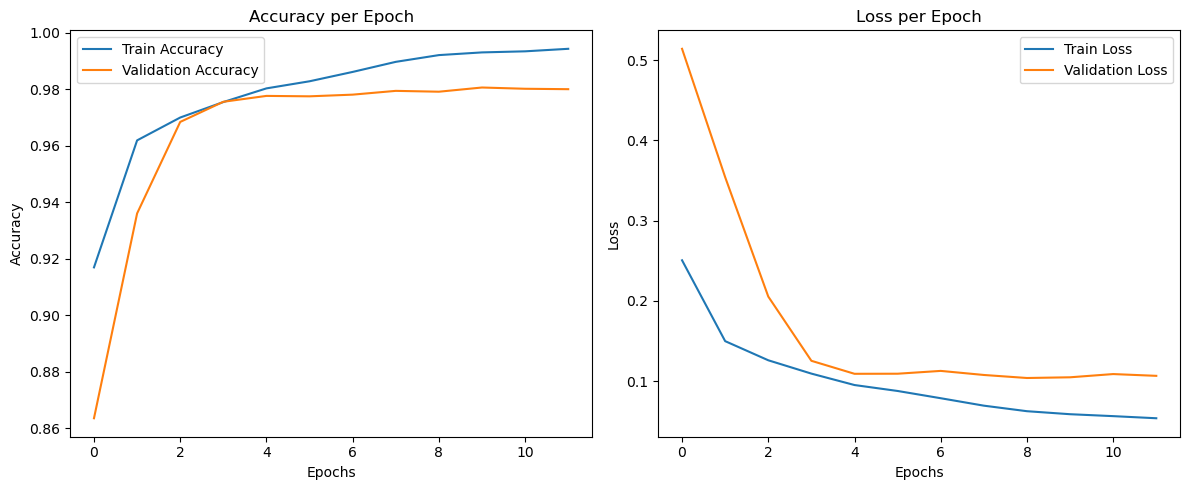

In [9]:
# =========================================
# Andamento Accuracy e Loss per epoca
# =========================================
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy per Epoch')

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss per Epoch')

plt.tight_layout()
plt.show()


1. Accuracy

All’inizio la train accuracy parte dal ~91% e la validation accuracy addirittura più bassa (~86%).

In poche epoche, entrambe crescono rapidamente: la validation supera il 97–98% già entro la terza-quarta epoca.

Dopo la quinta epoca la curva di validation si stabilizza attorno al 98%, mentre quella di training continua a crescere leggermente fino a sfiorare il 99.5%.

Questo divario è piccolo (circa 1.5%), segno che il modello generalizza bene ma sta iniziando a “specializzarsi” un po’ troppo sui dati di training → segnale di inizio overfitting.

2. Loss

La train loss scende regolarmente da ~0.25 a <0.05: il modello riduce costantemente l’errore sui dati che vede.

La validation loss cala rapidamente da ~0.5 a ~0.1 nelle prime epoche, ma poi smette di migliorare e resta piatta (o con leggerissime oscillazioni).

Questo plateau è tipico quando il modello ha già estratto tutto il segnale utile dai dati: ulteriori epoche non portano miglioramenti sulla generalizzazione.

3. Cosa ci insegnano questi grafici

SBERT embeddings: il fatto che accuracy e loss partano già da valori molto alti conferma che le embedding di SBERT forniscono una rappresentazione del testo estremamente informativa. In altre parole, la rete non deve “imparare da zero” ma solo adattarsi a separare classi in uno spazio già ben organizzato.

Plateau precoce: il modello impara quasi tutto nelle prime 3–5 epoche. Questo ci insegna che, con embedding potenti, non serve addestrare a lungo → early stopping è la scelta giusta.

Overfitting contenuto: la piccola differenza tra train e validation è fisiologica. In un contesto didattico, questo è l’esempio perfetto per mostrare la differenza tra “underfitting” (modello troppo debole), “buona generalizzazione” (fase centrale di questi grafici) e “inizio overfitting” (quando il train continua a migliorare ma la validation non più).

4. Messaggio agli studenti

Questi grafici mostrano come embedding di qualità + rete semplice possano produrre performance eccellenti in poche epoche.
La lezione didattica è duplice:

Non serve sempre un modello complesso: quando le feature sono potenti (come SBERT), bastano poche epoche e una rete leggera.

Bisogna sempre monitorare validation loss e accuracy: il plateau ci dice chiaramente quando fermarci per evitare addestramento inutile o overfitting.

“L’andamento di accuracy e loss mostra che la rete neurale, addestrata su embedding SBERT, raggiunge rapidamente un’elevata capacità predittiva: la validation accuracy si stabilizza intorno al 98% dopo poche epoche, mentre la train accuracy continua a crescere leggermente, segnalando un overfitting minimo. L’andamento conferma l’efficacia delle embedding SBERT e l’importanza di fermare l’addestramento una volta raggiunto il plateau.”

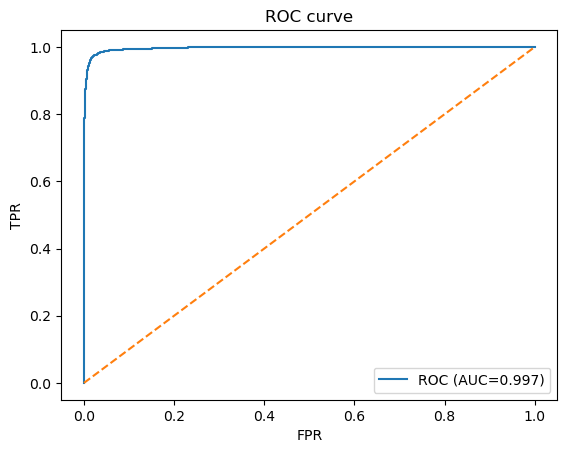

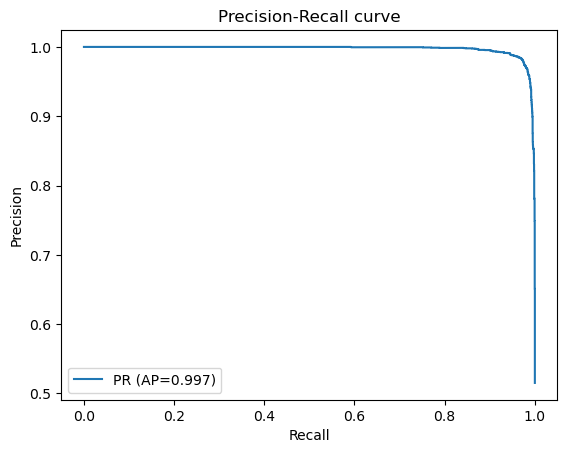

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, average_precision_score

# ROC
fpr, tpr, _ = roc_curve(y_test, probs)
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc_score(y_test, probs):.3f})")
plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.legend()
plt.show()

# PR
ap = average_precision_score(y_test, probs)
pr_prec, pr_rec, _ = precision_recall_curve(y_test, probs)
plt.plot(pr_rec, pr_prec, label=f"PR (AP={ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")
plt.legend()
plt.show()


1. ROC curve (Receiver Operating Characteristic)

L’asse X rappresenta il False Positive Rate (FPR) e l’asse Y il True Positive Rate (TPR).

La curva blu sale quasi verticalmente verso l’alto e rimane aderente al bordo superiore del grafico: questo significa che il modello ottiene molti veri positivi mantenendo pochissimi falsi positivi.

L’AUC = 0.997 è praticamente perfetto: in media, il modello distingue correttamente tra una notizia vera e una fake il 99.7% delle volte, indipendentemente dalla soglia di decisione.

La linea arancione tratteggiata rappresenta un classificatore casuale: il fatto che la curva sia molto distante da essa conferma l’elevata capacità discriminante del modello.

2. Precision–Recall curve

Qui l’asse X è il Recall (quanti fake vengono correttamente trovati) e l’asse Y la Precision (quanti dei casi classificati come fake sono davvero fake).

La curva rimane altissima e quasi piatta fino a valori di recall molto vicini a 1. Solo nell’ultimo tratto, quando si cerca di catturare il 100% dei casi, la precision cala rapidamente: un comportamento normale, perché aumentando la sensibilità si pagano alcuni falsi positivi.

L’AP (Average Precision) = 0.997, anch’esso altissimo, indica che il modello mantiene un equilibrio eccellente tra precision e recall lungo tutte le soglie.

3. Interpretazione didattica

Questi grafici insieme ci dicono che il modello è altamente efficace: non solo distingue bene le classi in senso generale (ROC), ma lo fa mantenendo contemporaneamente valori elevatissimi di precision e recall (PR).

Per gli studenti è importante capire che la ROC curve può apparire molto buona anche su dataset sbilanciati, mentre la Precision–Recall curve fornisce una visione più realistica della performance quando la classe positiva è rara. Il fatto che entrambe siano vicine al valore massimo dà una forte conferma della robustezza del modello.

Tuttavia, valori così perfetti devono sempre essere presi con cautela: potrebbero riflettere un dataset relativamente facile da separare o la presenza di data leakage. È fondamentale verificare che il test set sia indipendente e rappresentativo.

4. Messaggio agli studenti

ROC curve: ci mostra che il modello distingue con grande precisione i due tipi di notizie, con un margine enorme rispetto al caso casuale.

Precision–Recall curve: ci dice che non solo classifica bene, ma lo fa senza sacrificare precisione o richiamo.

Insieme, le due curve mostrano un modello quasi perfetto: un esempio ideale per capire come combinare più metriche per valutare un classificatore in modo completo.

“Le curve ROC e Precision–Recall evidenziano un modello con capacità discriminante quasi perfetta: sia l’AUC che l’AP raggiungono 0.997. La ROC mostra che il classificatore mantiene un tasso elevatissimo di veri positivi con pochi falsi positivi, mentre la PR conferma un equilibrio quasi ideale tra precision e recall lungo tutte le soglie. Risultati così alti richiedono comunque una verifica per escludere overfitting o data leakage.”

In [10]:
print(classification_report(y_test, pred_best, digits=3))

              precision    recall  f1-score   support

           0      0.983     0.971     0.977      3212
           1      0.974     0.985     0.979      3523

    accuracy                          0.978      6735
   macro avg      0.978     0.978     0.978      6735
weighted avg      0.978     0.978     0.978      6735



In [11]:
from sklearn.metrics import classification_report
import pandas as pd

# Supponiamo di avere y_true e y_pred (reti neurali, soglia 0.5 o best_thr)
report = classification_report(y_test, pred_best, digits=3, output_dict=True)

# Nel report troviamo già 'accuracy' come singolo valore,
# e precision/recall/f1 sotto le chiavi 'weighted avg' o 'macro avg'
acc  = report['accuracy']
prec = report['macro avg']['precision']
rec  = report['macro avg']['recall']
f1   = report['macro avg']['f1-score']

# Costruiamo il dizionario per la NN
nn_metrics = {
    "model": "NeuralNetwork",
    "accuracy": acc,
    "precision": prec,
    "recall": rec,
    "f1": f1
}

nn_df = pd.DataFrame([nn_metrics])



In [12]:
nn_df

,model,accuracy,precision,recall,f1
0,NeuralNetwork,0.978025,0.978297,0.977703,0.977965


In [13]:
import pandas as pd

data = {
    "model": ["LogReg", "LinearSVM", "RandomForest", "KNN", "GaussianNB", "DecisionTree"],
    "accuracy": [0.970045, 0.969822, 0.926615, 0.895212, 0.869154, 0.830401],
    "precision": [0.972264, 0.972252, 0.921839, 0.932106, 0.876900, 0.820311],
    "recall": [0.970400, 0.969974, 0.939310, 0.862436, 0.872232, 0.865204],
    "f1": [0.971331, 0.971112, 0.930493, 0.895919, 0.874560, 0.842160]
}

dfNONN = pd.DataFrame(data)
dfNONN


,model,accuracy,precision,recall,f1
0,LogReg,0.970045,0.972264,0.970400,0.971331
1,LinearSVM,0.969822,0.972252,0.969974,0.971112
2,RandomForest,0.926615,0.921839,0.939310,0.930493
3,KNN,0.895212,0.932106,0.862436,0.895919
4,GaussianNB,0.869154,0.876900,0.872232,0.874560
5,DecisionTree,0.830401,0.820311,0.865204,0.842160


In [14]:
results_df = pd.concat([dfNONN, nn_df], ignore_index=True)
results_df.style.format({
    "accuracy": "{:.4f}",
    "precision": "{:.4f}",
    "recall": "{:.4f}",
    "f1": "{:.4f}"
})

results_df


,model,accuracy,precision,recall,f1
0,LogReg,0.970045,0.972264,0.970400,0.971331
1,LinearSVM,0.969822,0.972252,0.969974,0.971112
2,RandomForest,0.926615,0.921839,0.939310,0.930493
3,KNN,0.895212,0.932106,0.862436,0.895919
4,GaussianNB,0.869154,0.876900,0.872232,0.874560
5,DecisionTree,0.830401,0.820311,0.865204,0.842160
6,NeuralNetwork,0.978025,0.978297,0.977703,0.977965


In [15]:
results_df_rounded = results_df.round(4)


In [16]:
results_df_rounded

,model,accuracy,precision,recall,f1
0,LogReg,0.9700,0.9723,0.9704,0.9713
1,LinearSVM,0.9698,0.9723,0.9700,0.9711
2,RandomForest,0.9266,0.9218,0.9393,0.9305
3,KNN,0.8952,0.9321,0.8624,0.8959
4,GaussianNB,0.8692,0.8769,0.8722,0.8746
5,DecisionTree,0.8304,0.8203,0.8652,0.8422
6,NeuralNetwork,0.9780,0.9783,0.9777,0.9780


In [17]:
results_df_rounded.to_csv(r"C:\Users\DAVIDEPEDRETTI\Desktop\NLP_news\Transformers_Metrics.csv")